In [1]:
%matplotlib inline
%load_ext Cython
import matplotlib.pyplot as plt
import numpy as np
import numba as nb
import pandas as pd
import cython
from scipy.optimize import curve_fit

masses = {
    "P" : 0.93827203,
    "PIP" : 0.13957018,
    "KAON" : 0.493677
}

WARNING  Overriding pythran description with argspec information for: numpy.concatenate
WARNING  Overriding pythran description with argspec information for: numpy.empty_like


In [2]:
%%cython --annotate
import numpy as np
cimport numpy as cnp
from libc.math cimport sqrt
cimport cython

cdef float c_special_units = 29.9792458
cdef float MASS_PIP = 0.13957018

@np.vectorize
@cython.nonecheck(False)
@cython.cdivision(True)
def vertex_time(float sc_t, float sc_r, float r_beta):
    return 


@cython.nonecheck(False)
@cython.cdivision(True)
cdef float dt_calc(float mass, float vertex, float momentum, float sc_t, float sc_r):
    if momentum == 0 or sc_t == 0 or sc_r == 0:
        return 100
    cdef float r_beta = 1.0 / sqrt(1.0 + (mass / momentum) * (mass / momentum))
    cdef float vt = sc_t - sc_r / (r_beta * c_special_units)
    
    return vertex - vt

@np.vectorize
def calc_dt(float mass, float vertex, float momentum, float sc_t, float sc_r):
    return dt_calc(mass, vertex, momentum, sc_t, sc_r)


In [3]:
data = pd.read_csv("/Users/tylern/Desktop/show/deltaT.dat")
data = data.replace(0, np.nan)
data = data.dropna()
print(len(data))

2824325


In [4]:
data.head()

,sec,theta,phi,charge,vertex,p,sc_t,sc_r
0,3.0,0.430126,-0.442297,1.0,55.5219,2.308410,73.5635,499.756
2,4.0,0.960026,-1.965630,-1.0,48.7890,0.787715,66.5264,537.264
4,1.0,0.522632,1.641330,1.0,65.3677,0.804731,92.1960,523.770
7,5.0,0.502915,-2.636870,1.0,66.1954,0.358935,84.5807,500.577
9,6.0,0.440094,2.661290,1.0,60.4883,1.395380,81.1383,509.147


In [5]:
%time
for mass in masses:
    data[f"dt_{mass}"] = calc_dt(masses[mass], data.vertex, data.p, data.sc_t, data.sc_r)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs


In [6]:
data = data.dropna()
#data = data[(data.theta < 1.0) & (np.abs(data.dt_PIP) < 1.2)]
data.head()

,sec,theta,phi,charge,vertex,p,sc_t,sc_r,dt_P,dt_PIP,dt_KAON
0,3.0,0.430126,-0.442297,1.0,55.5219,2.308410,73.5635,499.756,-0.047127,-1.341091,-0.994579
2,4.0,0.960026,-1.965630,-1.0,48.7890,0.787715,66.5264,537.264,10.134499,0.462936,3.412491
4,1.0,0.522632,1.641330,1.0,65.3677,0.804731,92.1960,523.770,0.008034,-9.096390,-6.331627
7,5.0,0.502915,-2.636870,1.0,66.1954,0.358935,84.5807,500.577,28.347359,-0.469940,10.008751
9,6.0,0.440094,2.661290,1.0,60.4883,1.395380,81.1383,509.147,-0.184292,-3.581936,-2.635109


In [7]:
def two_gauss(x, *p):
    A, mu, sigma, A2, mu2, sigma2 = p
    g1 = A*np.exp(-(x-mu)**2/(2.*sigma**2))
    g2 = A2*np.exp(-(x-mu2)**2/(2.*sigma2**2))
    return g1+g2

def gauss(x, *p):
    A, mu, sigma = p
    g1 = A*np.exp(-(x-mu)**2/(2.*sigma**2))
    return g1

def poly(x, a, b, c, d):
    y = a*x**3 + b*x**2 + c*x + d
    return y


def get_slices(data, sec=1, charge=1, min_p = 0.0, max_p = 4.0, num_steps = 120, particle="dt_PIP", show=False):
    slices = []
    mom = np.linspace(min_p, max_p, num=num_steps, endpoint=True)
    d = data[(data.charge == charge) & (data.sec == sec)]
    for m in range(len(mom[:-1])):
        _min = mom[m]
        _max = mom[m+1]
        slic = d[(d.p > _min) & (d.p <= _max)]
        if len(slic) > 100:
            if show:
                ydata, xdata, _ = plt.hist(slic[particle], bins=200, range=(-5,5))
            else:
                ydata, xdata = np.histogram(slic[particle], bins=200, range=(-5,5))
                
            xdata = (xdata[1:] + xdata[:-1])/2.0
            try:
                p0 = [1.0, 0.0, 0.01]
                param_bounds=((0,    -0.5,  0),
                              (np.inf,0.5,  1.0)
                             )
                popt, pcov = curve_fit(gauss, xdata, ydata, p0=p0, bounds=param_bounds, method="trf", maxfev=10000)

                if popt[2] > 0.4:
                    x2 = xdata[xdata>-0.8]
                    y2 = ydata[xdata>-0.8]
                    popt, pcov = curve_fit(gauss, x2, y2, p0=p0, bounds=param_bounds, method="trf", maxfev=10000)
                
                if show:
                    plt.plot(xdata, gauss(xdata, *popt), 'r-',
                        label='fit: A=%5.3f, mu=%5.3f, sigma=%5.3f' % tuple(popt))
                    plt.legend()
                slices.append([(_min+_max)/2.0, popt[1], popt[2]])
            except RuntimeError:
                try:
                    p0 = [1.0, 0.0, 0.01]
                    param_bounds=((0,    -0.5,  0),
                                  (np.inf,0.5,  0.5)
                             )
                    popt, pcov = curve_fit(gauss, xdata, ydata, p0=p0, bounds=param_bounds, method="trf", maxfev=10000)
                    if show:
                        plt.plot(xdata, gauss(xdata, *popt), 'r-',
                             label='fit: A=%5.3f, mu=%5.3f, sigma=%5.3f' % tuple(popt))
                        plt.legend()
                        
                    if popt[2] < 1.0:
                        slices.append([(_min+_max)/2.0, popt[1], popt[2]])
                except RuntimeError:
                    pass
            else:
                pass
            
            if show:
                plt.show()
                
    return np.array(slices).T

In [8]:
slices = get_slices(data, min_p = 0.0, max_p = 2.5, num_steps = 250, show=False)

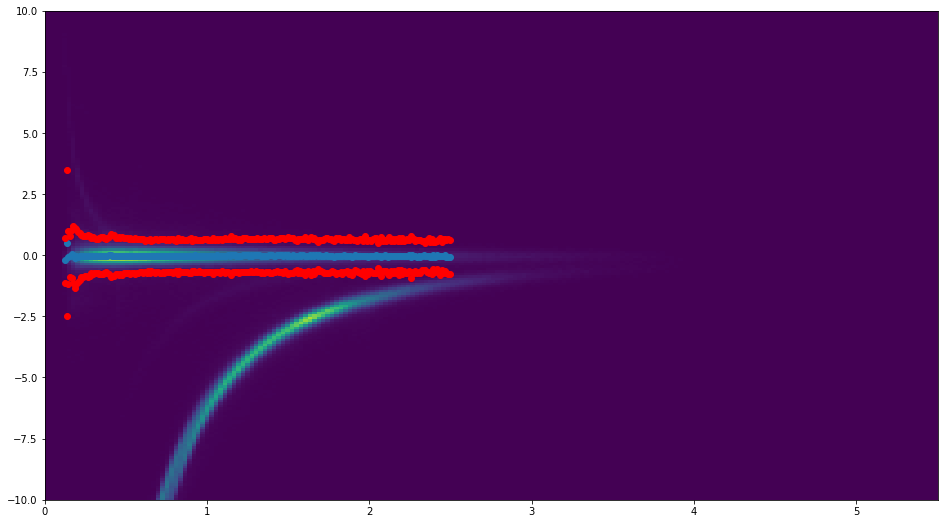

In [9]:
slice_p = slices[0]
mu = slices[1]
sigma = slices[2]

fig = plt.figure(figsize=(16,9))
plt.hist2d(data.p, data.dt_PIP, bins=200, range=((0, 5.5),(-10.0,10.0)))
plt.scatter(slice_p, mu)
plt.scatter(slice_p, mu+3*sigma, c='r')
plt.scatter(slice_p, mu-3*sigma, c='r')
plt.show()

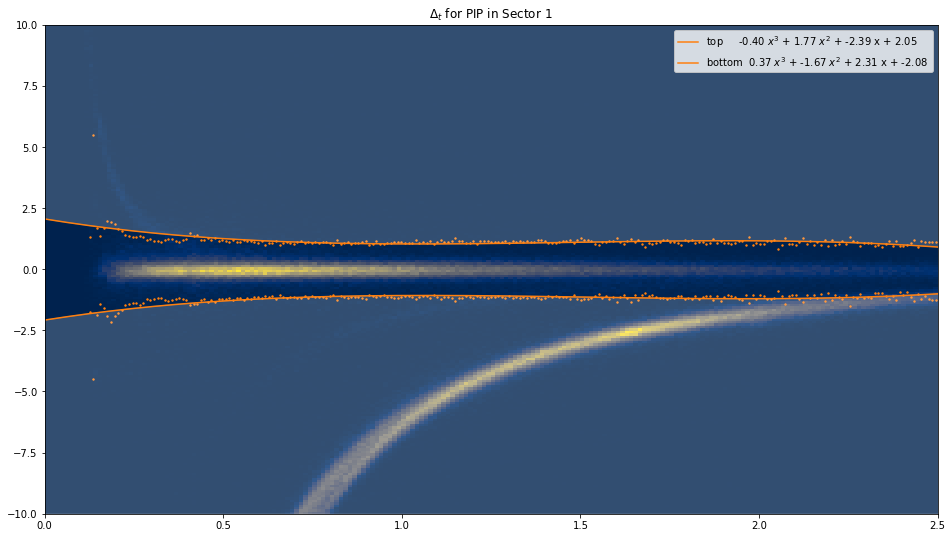

1 top PIP {-0.3983906378386617,1.7691591309743953,-2.391953234316428,2.053196037822996}
1 bottom PIP {0.3675382039188639,-1.6696350824727946,2.3059248487797204,-2.080500103861379}


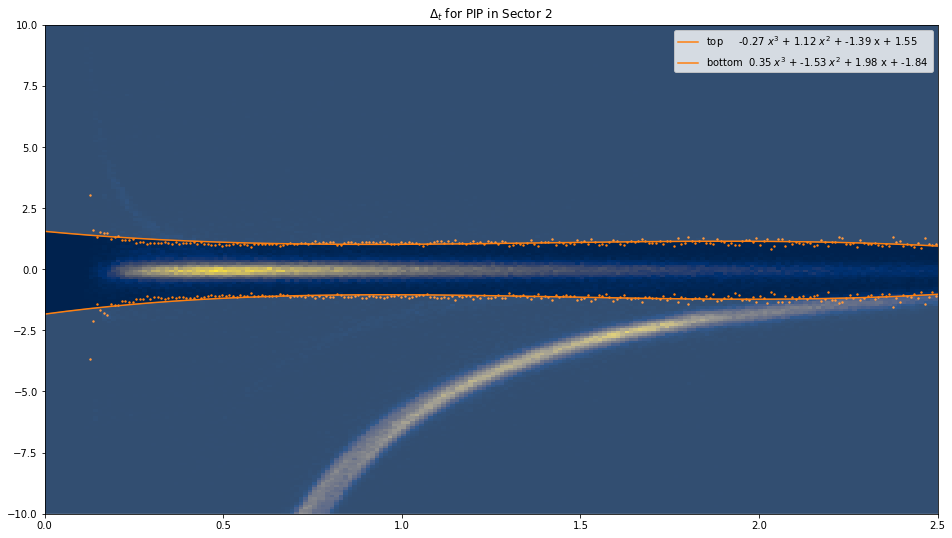

2 top PIP {-0.2650978766102774,1.1213680042253595,-1.3862713795438188,1.5465134585907463}
2 bottom PIP {0.3496842513383964,-1.5349758728247043,1.9755156624314831,-1.8362401000550146}


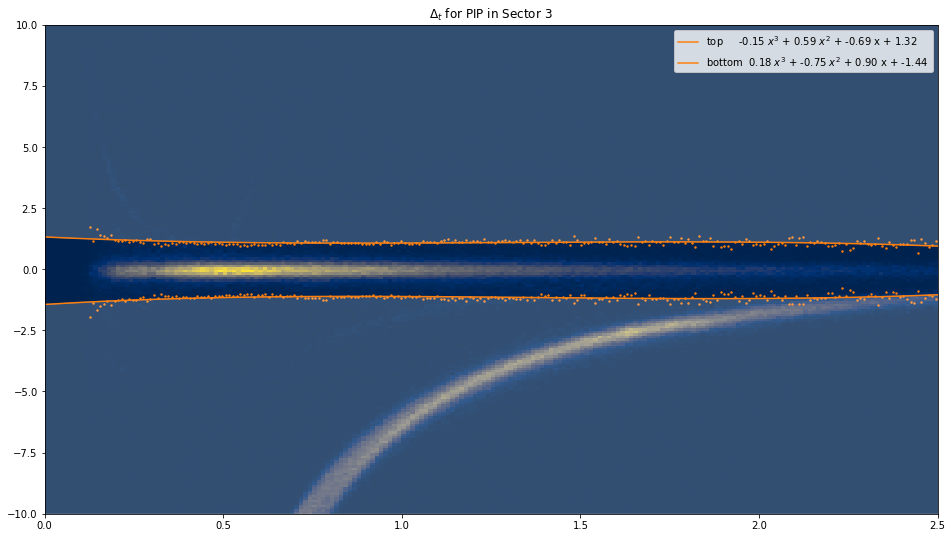

3 top PIP {-0.1500678497071529,0.5924126551536061,-0.6918174009859772,1.3167638980436909}
3 bottom PIP {0.1836326752696648,-0.7547275606778098,0.8964315234225131,-1.4413738592672618}


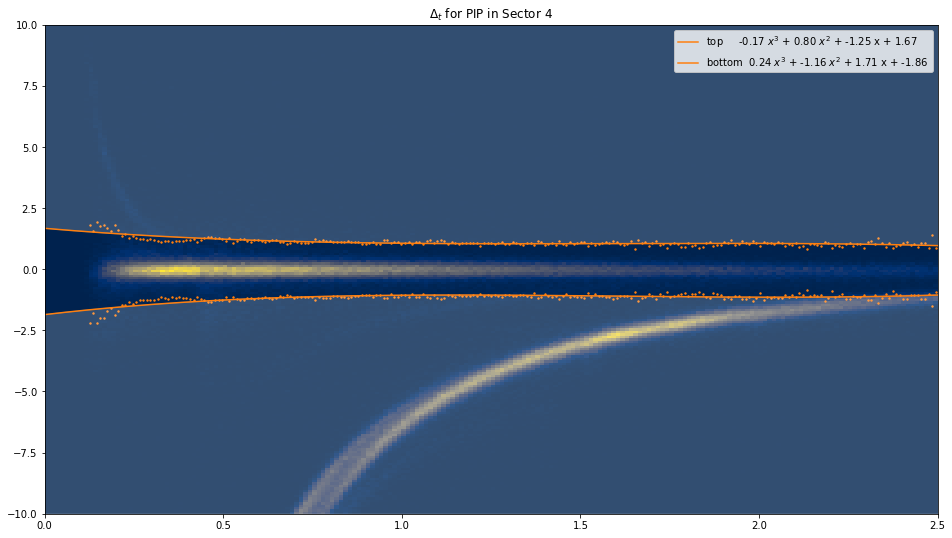

4 top PIP {-0.16696366053353448,0.8034639568490058,-1.2476301966896868,1.6700550558870049}
4 bottom PIP {0.241242822773932,-1.159395735694388,1.7098111532800238,-1.8565168163594157}


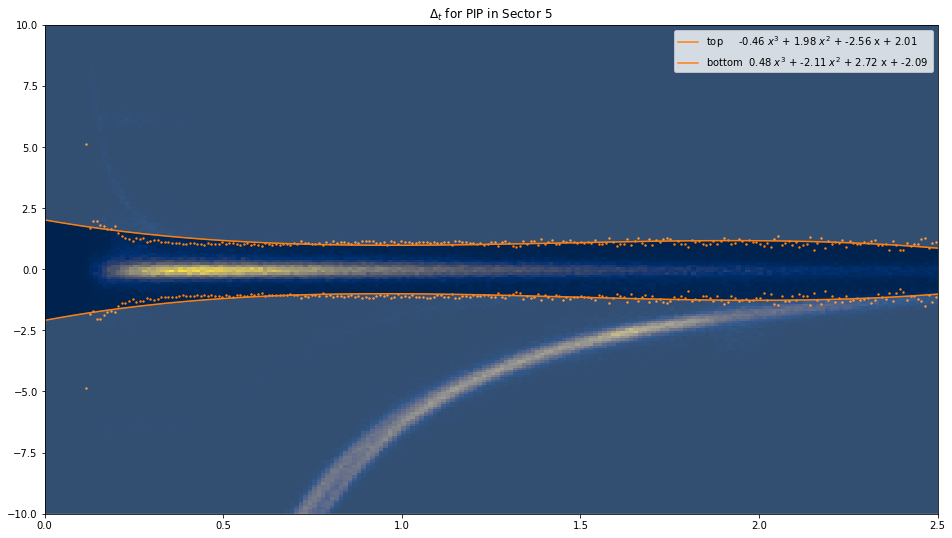

5 top PIP {-0.4556751164108001,1.9788681064674334,-2.559842464831547,2.012701089482115}
5 bottom PIP {0.4772585671349029,-2.1096055475337985,2.7197867953438104,-2.0912781533745486}


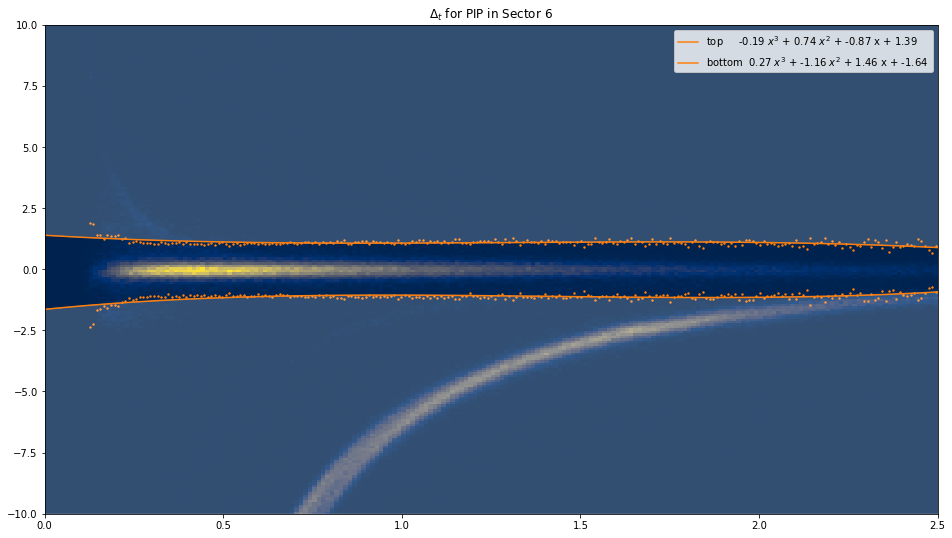

6 top PIP {-0.18802396742923716,0.7381915106114914,-0.8713447688764407,1.3865917786901185}
6 bottom PIP {0.27444035825873614,-1.1584402274276862,1.464738916878391,-1.6414726597382143}


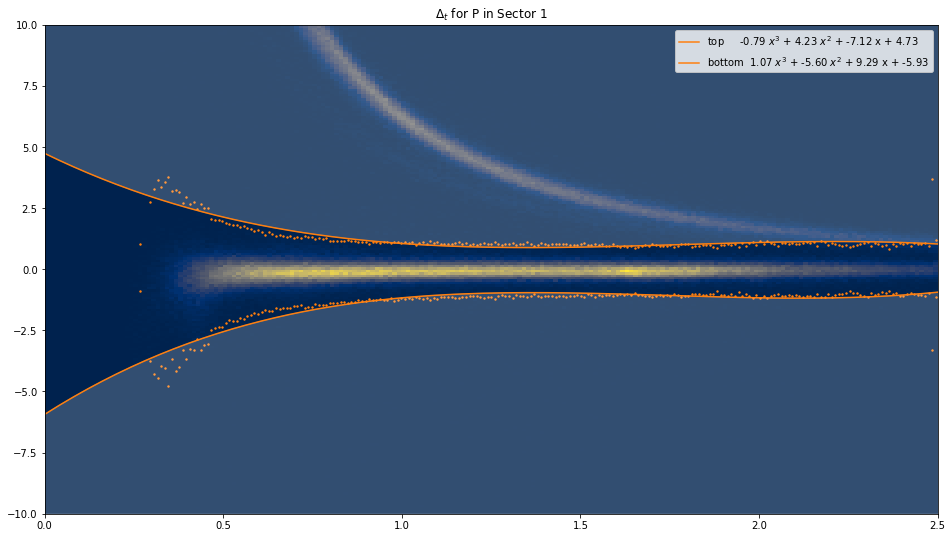

1 top P {-0.7881437010838698,4.226526927590258,-7.120784745613766,4.732297259330521}
1 bottom P {1.0743164668481124,-5.604449673638458,9.29392778568187,-5.934959821803871}


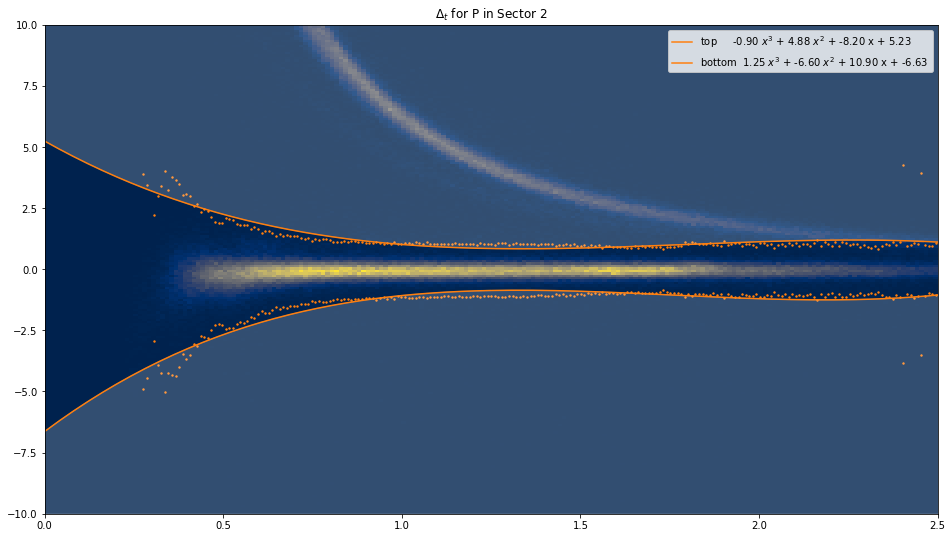

2 top P {-0.9033015641958689,4.877395377983768,-8.198185943080087,5.2348072759970385}
2 bottom P {1.2521587091147193,-6.599111096826978,10.902783520456289,-6.633906244170594}


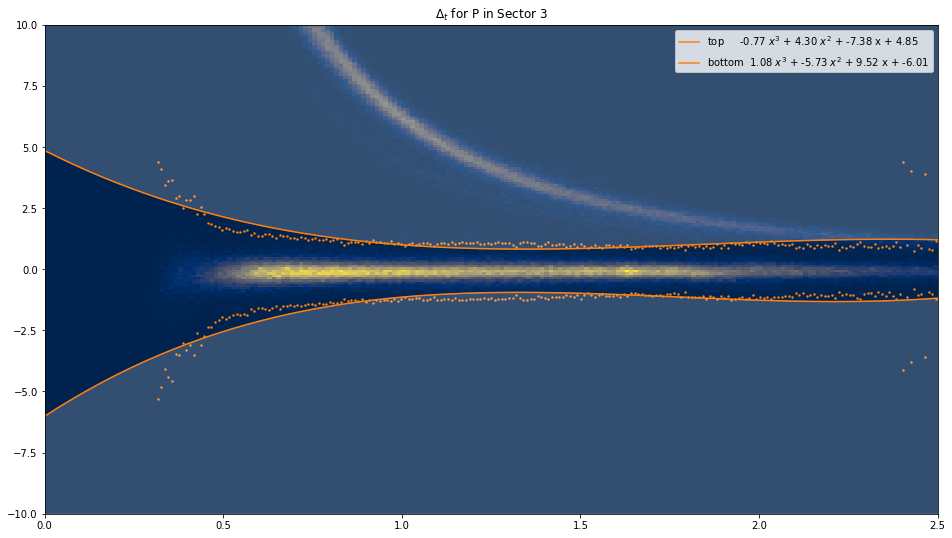

3 top P {-0.7716967328140293,4.297575850120338,-7.3798615324072,4.848740639824821}
3 bottom P {1.0770191494641963,-5.7283050359815535,9.520319590684018,-6.010866488438787}


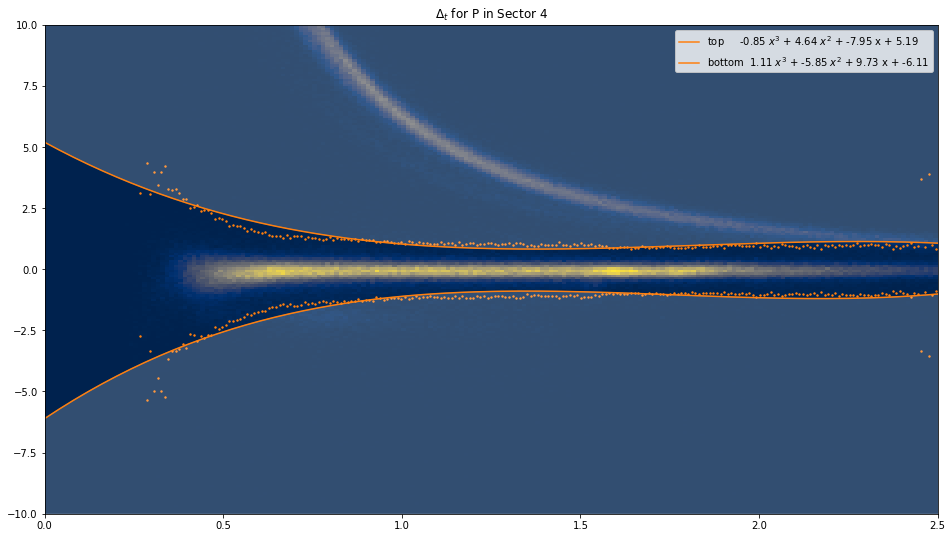

4 top P {-0.8467315907770491,4.637884189881309,-7.951614022273505,5.187603721487458}
4 bottom P {1.1063951440639375,-5.845580955164243,9.734865027933408,-6.105587755938904}


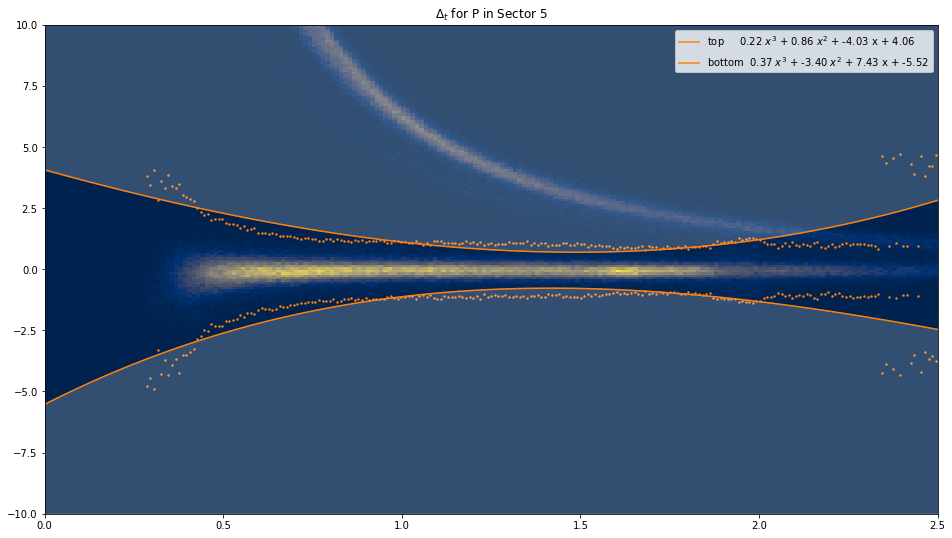

5 top P {0.22164449392409394,0.8584517352655793,-4.028592672418717,4.056245582358734}
5 bottom P {0.3662798691075725,-3.3977141807913167,7.430638292523305,-5.5248513332837765}


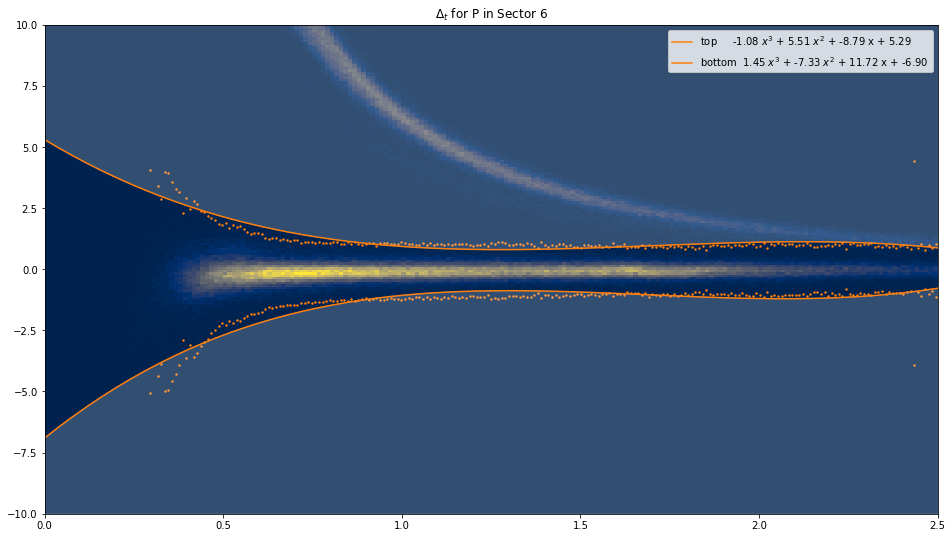

6 top P {-1.0785117885944016,5.5058644623066355,-8.79272875032769,5.294546979982571}
6 bottom P {1.4509532764975588,-7.334832136058423,11.717585505103925,-6.903355222107779}


In [10]:
for part in ["dt_PIP", "dt_P"]:
    for i in range(1,7):
        n_sigma = 5
        slices = get_slices(data, min_p = 0.0, max_p = 2.5, num_steps = 250, sec=i, particle=part)
        slice_p = slices[0][slices[2] > 0.1]
        mu = slices[1][slices[2] > 0.1]
        sigma = slices[2][slices[2] > 0.1]

        fig = plt.figure(figsize=(16,9))
        plt.title(f"$\Delta_t$ for {part[3:]} in Sector {i}")
        plt.hist2d(data[data.sec == i].p, data[data.sec == i][part], bins=200, range=((0, 2.5),(-10.0,10.0)), cmap='cividis')
        #plt.scatter(slice_p, mu, s=2.0, c='#bcbd22')
        plt.scatter(slice_p, mu+n_sigma*sigma, s=2.0, c='#ff7f0e')
        plt.scatter(slice_p, mu-n_sigma*sigma, s=2.0, c='#ff7f0e')
        
        xdata = np.linspace(0,4,200)
        popt_top, pcov_top = curve_fit(poly, slice_p, mu+n_sigma*sigma)
        plt.plot(xdata, poly(xdata, *popt_top), c='#ff7f0e', label=f'top\t{popt_top[0]:0.2f} $x^3$ + {popt_top[1]:0.2f} $x^2$ + {popt_top[2]:0.2f} x + {popt_top[3]:0.2f}')

        popt_bottom, pcov_bottom = curve_fit(poly, slice_p, mu-n_sigma*sigma)
        plt.plot(xdata, poly(xdata, *popt_bottom), c='#ff7f0e',label=f'bottom\t{popt_bottom[0]:0.2f} $x^3$ + {popt_bottom[1]:0.2f} $x^2$ + {popt_bottom[2]:0.2f} x + {popt_bottom[3]:0.2f}')
        
        plt.fill_between(xdata, poly(xdata, *popt_top), 10, alpha=0.2, color='white')
        plt.fill_between(xdata, poly(xdata, *popt_bottom), -10, alpha=0.2, color='white')
        plt.legend()
        
        
        plt.show()
        
        print(f"{i} top {part[3:]} {{{popt_top[0]},{popt_top[1]},{popt_top[2]},{popt_top[3]}}}")
        print(f"{i} bottom {part[3:]} {{{popt_bottom[0]},{popt_bottom[1]},{popt_bottom[2]},{popt_bottom[3]}}}")
        

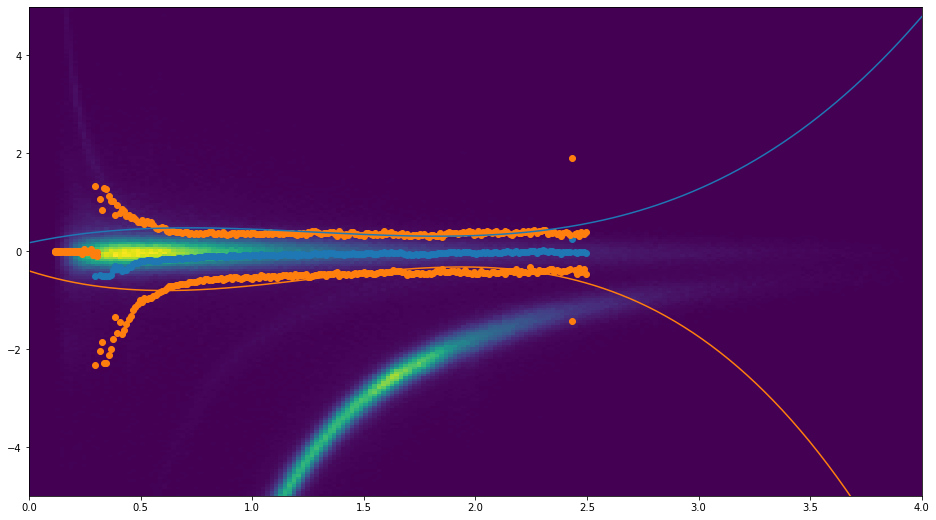

In [11]:
slice_p = slices[0]
mu = slices[1]
sigma = slices[2]

fig = plt.figure(figsize=(16,9))
plt.hist2d(data.p, data.dt_PIP, bins=200, range=((0, 4.0),(-5.0,5.0)))
plt.scatter(slice_p, mu)
plt.scatter(slice_p, mu+2*sigma, c='#ff7f0e')
plt.scatter(slice_p, mu-2*sigma, c='#ff7f0e')

popt, pcov = curve_fit(poly, slice_p, mu+2*sigma)
xdata = np.linspace(0,4,200)
plt.plot(xdata, poly(xdata, *popt))

popt, pcov = curve_fit(poly, slice_p, mu-2*sigma)
xdata = np.linspace(0,4,200)
plt.plot(xdata, poly(xdata, *popt))

plt.show()

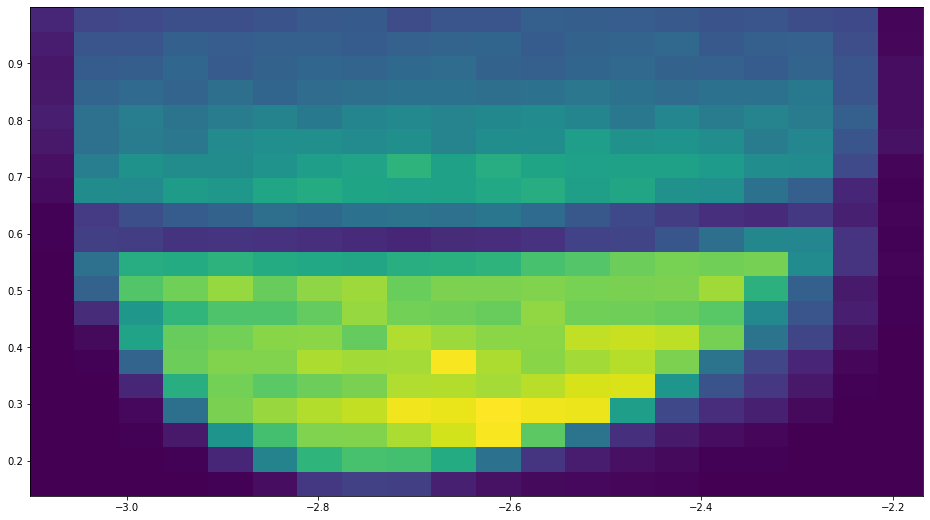

In [12]:
fig = plt.figure(figsize=(16,9))

d = data[(data.theta < 1.0) & (np.abs(data.dt_PIP) < 1.0) & (data.sec == 5)]
plt.hist2d(d.phi, d.theta, bins=20)
plt.show()